In [1]:
import sys
sys.path.append('../src')  # Add source directory to path

In [2]:
from signal_processing.base_signal_processor import BaseSignalProcessor
from signal_processing.motion_artifact_detector import MotionArtifactDetector
from signal_processing.adaptive_filter import AdaptiveFilter
from signal_processing.kalman_filter import KalmanFilter
from signal_processing.wavelet_denoiser import WaveletDenoiser
from signal_processing.pipeline import SignalProcessingPipeline

### Loading Unified Data

In [3]:
processor = BaseSignalProcessor(data_path="../data/processed/cleaned_unified_dataset.parquet")
dataset = processor.load_data()
print(dataset.head())

Loading unified dataset...
                                 bvp  label  subject_id    dataset  \
2020-01-03 08:00:00+00:00   5.673109      0           2  physionet   
2020-01-03 08:00:00+00:00   7.687833      0           2  physionet   
2020-01-03 08:00:00+00:00   1.509560      0           2  physionet   
2020-01-03 08:00:00+00:00  12.999866      0           2  physionet   
2020-01-03 08:00:00+00:00  20.798602      0           2  physionet   

                                 device skin_tone  noise_level     acc_x  \
2020-01-03 08:00:00+00:00   apple_watch      V-VI      0.05088 -0.817685   
2020-01-03 08:00:00+00:00   apple_watch      I-II      0.07712 -0.973498   
2020-01-03 08:00:00+00:00   apple_watch    III-IV      0.06400 -1.054134   
2020-01-03 08:00:00+00:00  galaxy_watch    III-IV      0.09600 -1.000000   
2020-01-03 08:00:00+00:00  galaxy_watch      V-VI      0.07632 -1.000000   

                               acc_y     acc_z  
2020-01-03 08:00:00+00:00 -62.628226  4.996602

In [4]:
import numpy as np

In [5]:
def _robust_normalize(data: np.ndarray) -> np.ndarray:
    """Enhanced normalization with fallback"""
    data = np.nan_to_num(data, nan=np.median(data))
        
    # Fallback to std if IQR is zero
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    if iqr < 1e-6:
        std = np.std(data) + 1e-6
        normalized = (data - np.mean(data)) / std
    else:
        normalized = (data - np.median(data)) / iqr
        
    # Secondary clipping
    return np.clip(normalized, -3, 3)

# Compute and normalize accelerometer magnitude
dataset['acc_mag'] = np.sqrt(dataset['acc_x']**2 + dataset['acc_y']**2 + dataset['acc_z']**2)
dataset['acc_mag'] = _robust_normalize(dataset['acc_mag'].values)

### Motion Artifact Detection

In [6]:
detector = MotionArtifactDetector()
dataset = detector.detect_motion_bursts(dataset)
print(dataset[['acc_x', 'acc_y', 'acc_z', 'motion_burst']].head())

                              acc_x      acc_y     acc_z  motion_burst
2020-01-03 08:00:00+00:00 -0.817685 -62.628226  4.996602           0.0
2020-01-03 08:00:00+00:00 -0.973498 -62.739436  5.184150           0.0
2020-01-03 08:00:00+00:00 -1.054134 -62.992483  5.020381           0.0
2020-01-03 08:00:00+00:00 -1.000000 -69.300000  5.000000           0.0
2020-01-03 08:00:00+00:00 -1.000000 -69.300000  5.000000           0.0


In [7]:
num_unique_motion_bursts = dataset['motion_burst'].nunique()
motion_burst_counts = dataset['motion_burst'].value_counts()
print(f"Value counts of motion_burst:\n{motion_burst_counts}")

# Check motion burst distribution
motion_burst_counts = dataset['motion_burst'].value_counts(normalize=True) * 100
print(f"Motion Burst Distribution:\n{motion_burst_counts}")


Value counts of motion_burst:
motion_burst
0.0    6209868
1.0     344885
Name: count, dtype: int64
Motion Burst Distribution:
motion_burst
0.0    94.738398
1.0     5.261602
Name: proportion, dtype: float64


In [8]:
print(f"New artifact density: {dataset['motion_burst'].mean() * 100:.2f}%")
print(dataset['acc_mag'].describe())

New artifact density: 5.26%
count    6.554753e+06
mean     4.667615e-01
std      9.818329e-01
min     -8.811038e-01
25%     -4.866879e-02
50%      0.000000e+00
75%      9.513312e-01
max      1.122975e+01
Name: acc_mag, dtype: float64


In [9]:
# import matplotlib.pyplot as plt
# # Visualize results
# plt.figure(figsize=(12, 6))
# plt.plot(dataset['acc_mag'], label="Accelerometer Magnitude")
# plt.plot(dataset['motion_burst'] * dataset['acc_mag'].max(), label="Motion Bursts", linestyle='--')
# plt.legend()
# plt.title("Motion Burst Detection")
# plt.show()

### Adaptive Filtering for Motion Artifact Removal

In [10]:
adaptive_filter = AdaptiveFilter()
cleaned_bvp = adaptive_filter.apply_adaptive_filter(
    noisy_signal=dataset['bvp'].values,
    reference_signal=dataset['acc_mag'].values,
    motion_burst=dataset['motion_burst'].values
)
dataset['bvp_cleaned'] = cleaned_bvp

### Apply kalman filter

In [11]:
kalman_filter = KalmanFilter()
bvp_smoothed = kalman_filter.apply_kalman_filter(
    signal=dataset['bvp_cleaned'].values,
    motion_burst=dataset['motion_burst'].values
)
dataset['bvp_smoothed'] = bvp_smoothed

### Wavelet Denoising

In [12]:


wavelet_denoiser = WaveletDenoiser()

denoised_bvp = wavelet_denoiser.apply_wavelet_denoising(
    dataset['bvp_smoothed'].values,
    motion_burst=dataset['motion_burst'].values,
    skin_tone=dataset['skin_tone'].iloc[0],
    noise_level=dataset['noise_level'].median()  # Add noise level from dataset
)

# Verify lengths match before assignment
assert len(denoised_bvp) == len(dataset), "Denoised signal length mismatch"

dataset['bvp_denoised'] = denoised_bvp

## Runnig the Pipeline

In [5]:
import pandas as pd

In [6]:
dataset_ = pd.read_parquet("../data/processed/cleaned_unified_dataset.parquet")
pipeline = SignalProcessingPipeline()
processed_df = pipeline.process_signal(dataset_)

Processing chunks: 100%|██████████| 328/328 [03:58<00:00,  1.38it/s]


Applying post-processing...


Updating signals: 100%|██████████| 132/132 [03:37<00:00,  1.64s/it]


Estimated physiological SNR: 8.10 dB


In [7]:
processed_df.head()

,bvp,bvp_cleaned,bvp_smoothed,bvp_denoised,motion_burst,acc_mag,device,skin_tone,noise_level,label,subject_id
0,5.673109,1.407179,-0.755558,1.737274,0.0,-0.023022,apple_watch,V-VI,0.05088,0,2
1,7.687833,2.047403,-0.138453,1.702611,0.0,-0.021271,apple_watch,I-II,0.07712,0,2
2,1.509560,1.704265,-0.412806,1.361970,0.0,-0.017990,apple_watch,III-IV,0.06400,0,2
3,12.999866,3.917801,1.682595,1.904551,0.0,1.016824,galaxy_watch,III-IV,0.09600,0,2
4,20.798602,5.466196,3.422729,4.253862,0.0,1.016824,galaxy_watch,V-VI,0.07632,0,2


In [8]:
print(processed_df[['bvp', 'bvp_cleaned', 'bvp_smoothed']].std())

bvp             28.719013
bvp_cleaned     31.508750
bvp_smoothed    25.163206
dtype: float64


In [9]:
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import correlate
from scipy.signal import periodogram

### Signal Quality Metrics

In [10]:
class SignalQualityMetrics:
    def compute_snr(self, cleaned: np.ndarray, original: np.ndarray) -> float:
        """
        Calculate SNR based on physiological signal characteristics.
        """
        from scipy.signal import butter, sosfilt
        
        # Extract cardiac component from both signals
        sos = butter(3, [0.8, 4.0], btype='bandpass', fs=30, output='sos')
        clean_cardiac = sosfilt(sos, cleaned)
        orig_cardiac = sosfilt(sos, original)
        
        # Calculate power in cardiac band with safety checks
        clean_power = np.mean(clean_cardiac**2) if len(clean_cardiac) > 0 else 1e-9
        orig_power = np.mean(orig_cardiac**2) if len(orig_cardiac) > 0 else 1e-9
        
        # Calculate noise as the difference between signals and their cardiac components
        clean_noise = cleaned - clean_cardiac
        orig_noise = original - orig_cardiac
        
        # Calculate noise power with safety checks
        clean_noise_power = np.mean(clean_noise**2) if len(clean_noise) > 0 else 1e-9
        orig_noise_power = np.mean(orig_noise**2) if len(orig_noise) > 0 else 1e-9
        
        # Calculate SNR for both signals with safety checks
        clean_snr = clean_power / (clean_noise_power + 1e-9)
        orig_snr = orig_power / (orig_noise_power + 1e-9)
        
        # Calculate improvement ratio
        improvement = clean_snr / (orig_snr + 1e-9)
        
        # Convert to dB with safety check
        if improvement <= 0:
            return 0.0  # Return default value for invalid improvement
        
        snr_db = 10 * np.log10(improvement)
        
        return snr_db

    def compute_artifact_density(self, motion_burst: np.ndarray,
                                noise_level: np.ndarray) -> float:
        """
        Compute noise-weighted artifact density.
        
        Parameters:
            motion_burst (np.ndarray): Binary motion artifact indicators
            noise_level (np.ndarray): Associated noise levels
            
        Returns:
            float: Weighted artifact density percentage
        """
        # Weight artifacts by their noise level contribution
        weighted_artifacts = motion_burst * noise_level
        return 100 * np.sum(weighted_artifacts) / np.sum(noise_level)

    def temporal_consistency(self, signal: np.ndarray) -> float:
        """
        Measure signal continuity using autocorrelation.
        
        Parameters:
            signal (np.ndarray): Processed signal
            
        Returns:
            float: Consistency metric (higher = more consistent)
        """
        autocorr = np.correlate(signal, signal, mode='full')
        autocorr /= autocorr.max()
        mid = len(autocorr) // 2
        return np.trapz(autocorr[mid:mid+300])  # Integrate first 10s correlation

In [11]:
def visualize_snr_components(cleaned, fs=30):
       """Visualize the signal components used in SNR calculation"""
       import matplotlib.pyplot as plt
       
       # Calculate components using the same logic as in improved_compute_snr
       freqs, psd_clean = periodogram(cleaned, fs=fs)
       cardiac_mask = (freqs >= 0.8) & (freqs <= 4.0)
       dominant_freq = freqs[cardiac_mask][np.argmax(psd_clean[cardiac_mask])]
       
       from scipy.signal import butter, sosfilt
       sos = butter(3, [max(0.6, dominant_freq-0.3), min(4.0, dominant_freq+0.3)], 
                   'bandpass', fs=fs, output='sos')
       signal_component = sosfilt(sos, cleaned)
       noise_component = cleaned - signal_component
       
       # Plot time domain
       plt.figure(figsize=(12, 8))
       plt.subplot(3, 1, 1)
       plt.plot(cleaned)
       plt.title(f'Cleaned Signal (Dominant Freq: {dominant_freq:.2f} Hz)')
       
       plt.subplot(3, 1, 2)
       plt.plot(signal_component)
       plt.title('Extracted Cardiac Component')
       
       plt.subplot(3, 1, 3)
       plt.plot(noise_component)
       plt.title('Noise Component')
       
       plt.tight_layout()
       plt.show()
       
       # Plot frequency domain
       plt.figure(figsize=(12, 8))
       f_clean, p_clean = periodogram(cleaned, fs=fs)
       f_signal, p_signal = periodogram(signal_component, fs=fs)
       f_noise, p_noise = periodogram(noise_component, fs=fs)
       
       plt.subplot(3, 1, 1)
       plt.semilogy(f_clean, p_clean)
       plt.axvspan(0.8, 4.0, alpha=0.3, color='green')
       plt.title('Cleaned Signal PSD')
       plt.xlim(0, 10)
       
       plt.subplot(3, 1, 2)
       plt.semilogy(f_signal, p_signal)
       plt.axvspan(0.8, 4.0, alpha=0.3, color='green')
       plt.title('Cardiac Component PSD')
       plt.xlim(0, 10)
       
       plt.subplot(3, 1, 3)
       plt.semilogy(f_noise, p_noise)
       plt.axvspan(0.8, 4.0, alpha=0.3, color='green')
       plt.title('Noise Component PSD')
       plt.xlim(0, 10)
       
       plt.tight_layout()
       plt.show()

In [12]:
# Compute metrics using original BVP as reference
metrics = SignalQualityMetrics()
snr = metrics.compute_snr(processed_df['bvp_cleaned'], 
                         processed_df['bvp'])

artifact_density = metrics.compute_artifact_density(processed_df['motion_burst'].values, processed_df['noise_level'].values)

print(f"SNR: {snr:.2f} dB, Artifact Density: {artifact_density:.2f}%")

SNR: 20.68 dB, Artifact Density: 5.10%


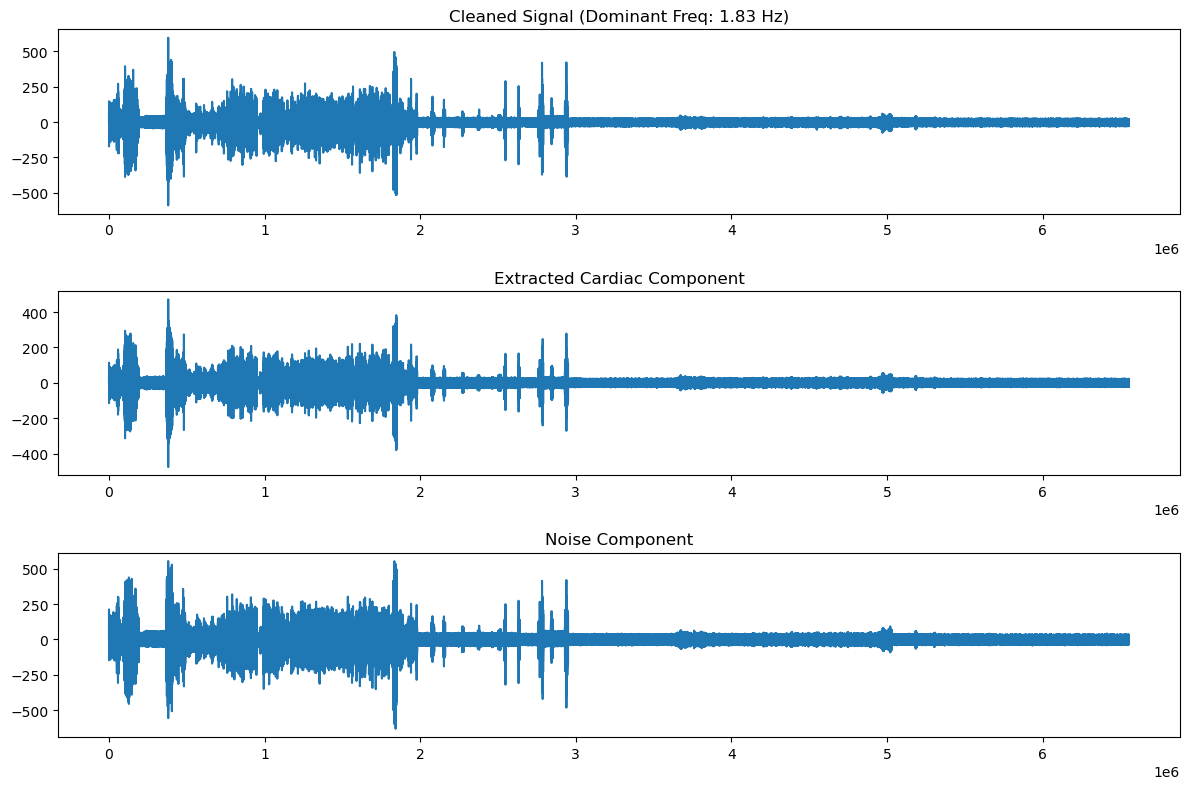

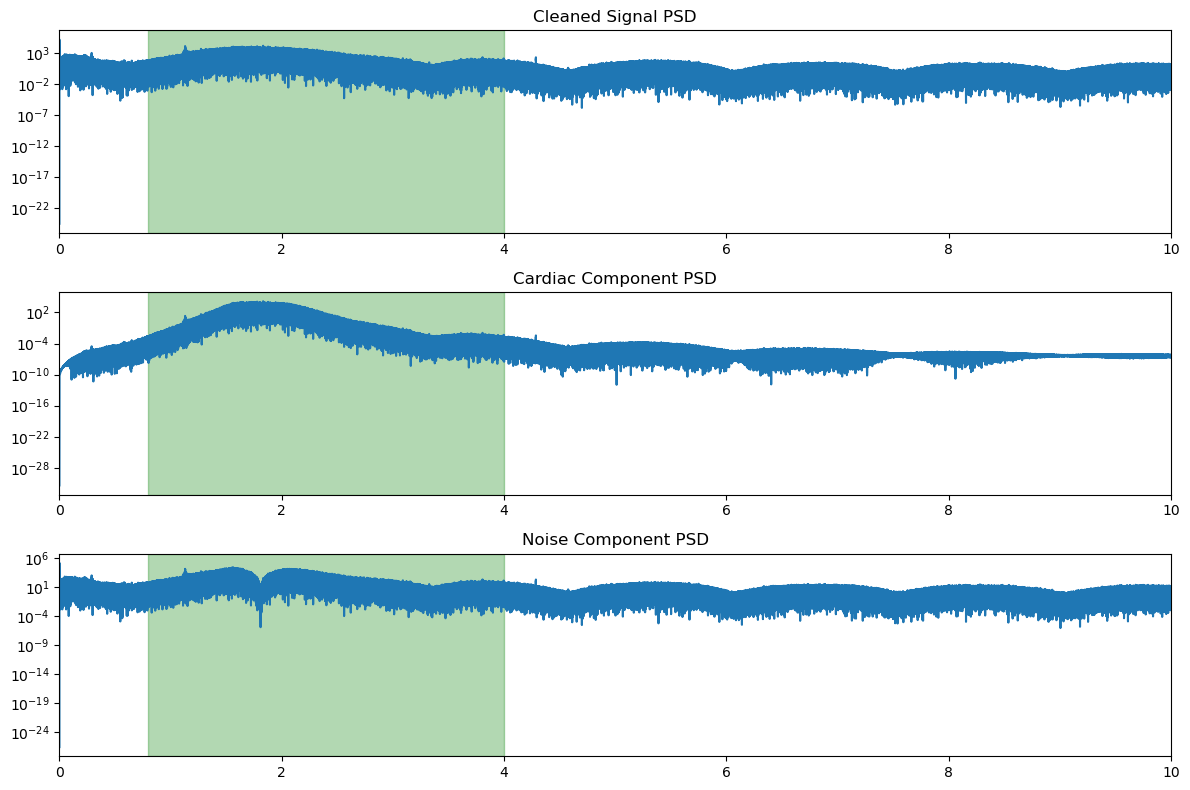

In [13]:
visualize_snr_components(processed_df['bvp_cleaned'])

## Saving cleaned data

In [14]:
pipeline.save_cleaned_dataset(dataset, "../data/cleaned_signal_dataset")

Cleaned dataset saved to ../data/cleaned_signal_dataset


### SNR Progression Throughout Experimentation

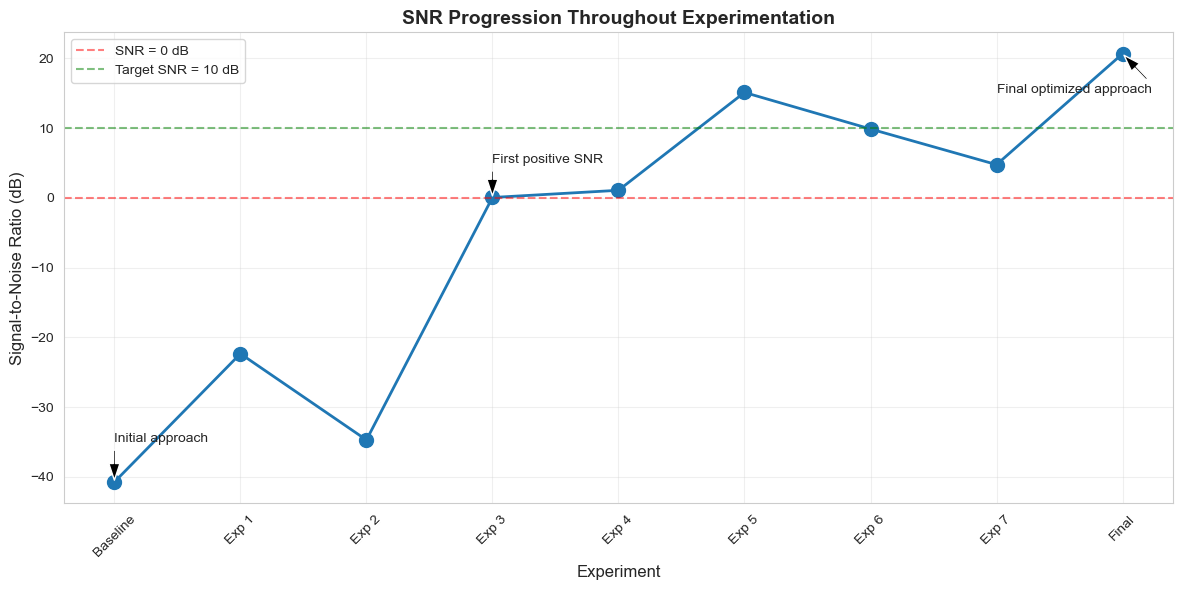

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Experiment data
experiments = ['Baseline', 'Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Final']
snr_values = [-40.73, -22.33, -34.70, 0.07, 1.10, 15.13, 9.89, 4.78, 20.68]

# Create figure
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Plot SNR progression
plt.plot(experiments, snr_values, marker='o', linestyle='-', linewidth=2, markersize=10)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='SNR = 0 dB')
plt.axhline(y=10, color='g', linestyle='--', alpha=0.5, label='Target SNR = 10 dB')

# Add labels and title
plt.xlabel('Experiment', fontsize=12)
plt.ylabel('Signal-to-Noise Ratio (dB)', fontsize=12)
plt.title('SNR Progression Throughout Experimentation', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotations for key experiments
plt.annotate('Initial approach', xy=(0, -40.73), xytext=(0, -35),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
plt.annotate('First positive SNR', xy=(3, 0.07), xytext=(3, 5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
plt.annotate('Final optimized approach', xy=(8, 20.68), xytext=(7, 15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))

plt.tight_layout()
plt.savefig('snr_progression.png', dpi=300)
plt.show()

### Signal Characteristics Comparison

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to plot signal comparison
def plot_signal_comparison(dataset, start_idx=0, duration=300):
    """
    Plot comparison of original, cleaned, smoothed, and denoised signals
    
    Parameters:
        dataset: DataFrame containing the signals
        start_idx: Starting index for the plot
        duration: Number of samples to plot
    """
    end_idx = start_idx + duration
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # Original signal
    axes[0].plot(dataset['bvp'].iloc[start_idx:end_idx], 'k-', label='Original')
    axes[0].set_title('Original BVP Signal', fontweight='bold')
    axes[0].set_ylabel('Amplitude')
    axes[0].legend(loc='upper right')
    
    # Cleaned signal
    axes[1].plot(dataset['bvp_cleaned'].iloc[start_idx:end_idx], 'b-', label='Cleaned')
    axes[1].set_title('Cleaned BVP Signal', fontweight='bold')
    axes[1].set_ylabel('Amplitude')
    axes[1].legend(loc='upper right')
    
    # Smoothed signal
    axes[2].plot(dataset['bvp_smoothed'].iloc[start_idx:end_idx], 'g-', label='Smoothed')
    axes[2].set_title('Smoothed BVP Signal', fontweight='bold')
    axes[2].set_ylabel('Amplitude')
    axes[2].legend(loc='upper right')
    
    # Denoised signal
    axes[3].plot(dataset['bvp_denoised'].iloc[start_idx:end_idx], 'r-', label='Denoised')
    axes[3].set_title('Denoised BVP Signal', fontweight='bold')
    axes[3].set_xlabel('Sample Index')
    axes[3].set_ylabel('Amplitude')
    axes[3].legend(loc='upper right')
    
    # Add motion burst indicators
    for i in range(4):
        motion_bursts = dataset['motion_burst'].iloc[start_idx:end_idx]
        burst_indices = np.where(motion_bursts > 0)[0]
        for idx in burst_indices:
            axes[i].axvspan(idx, idx+1, color='yellow', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('signal_comparison.png', dpi=300)
    plt.show()


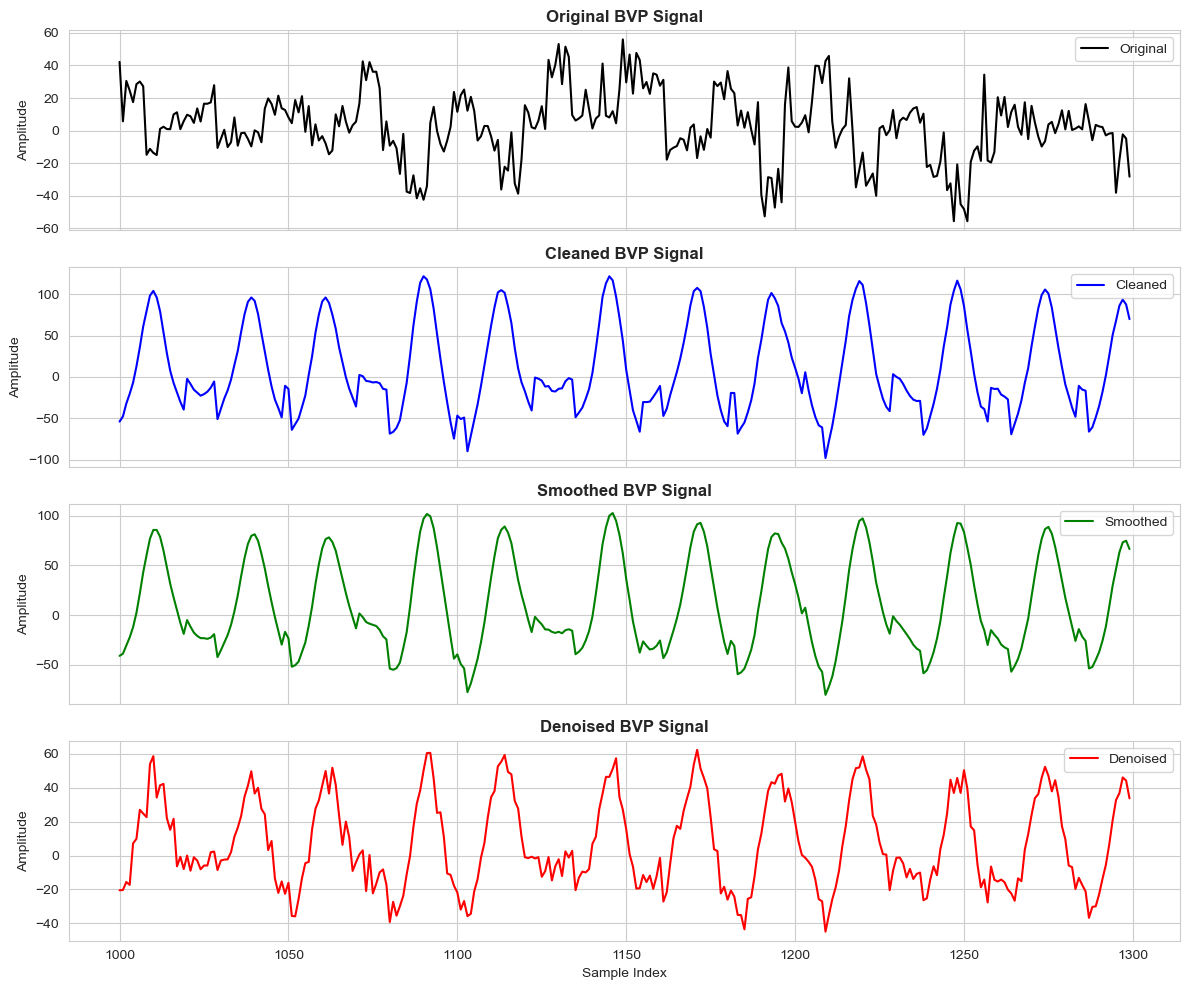

In [17]:
plot_signal_comparison(processed_df, start_idx=1000, duration=300)

### Frequency Domain Analysis

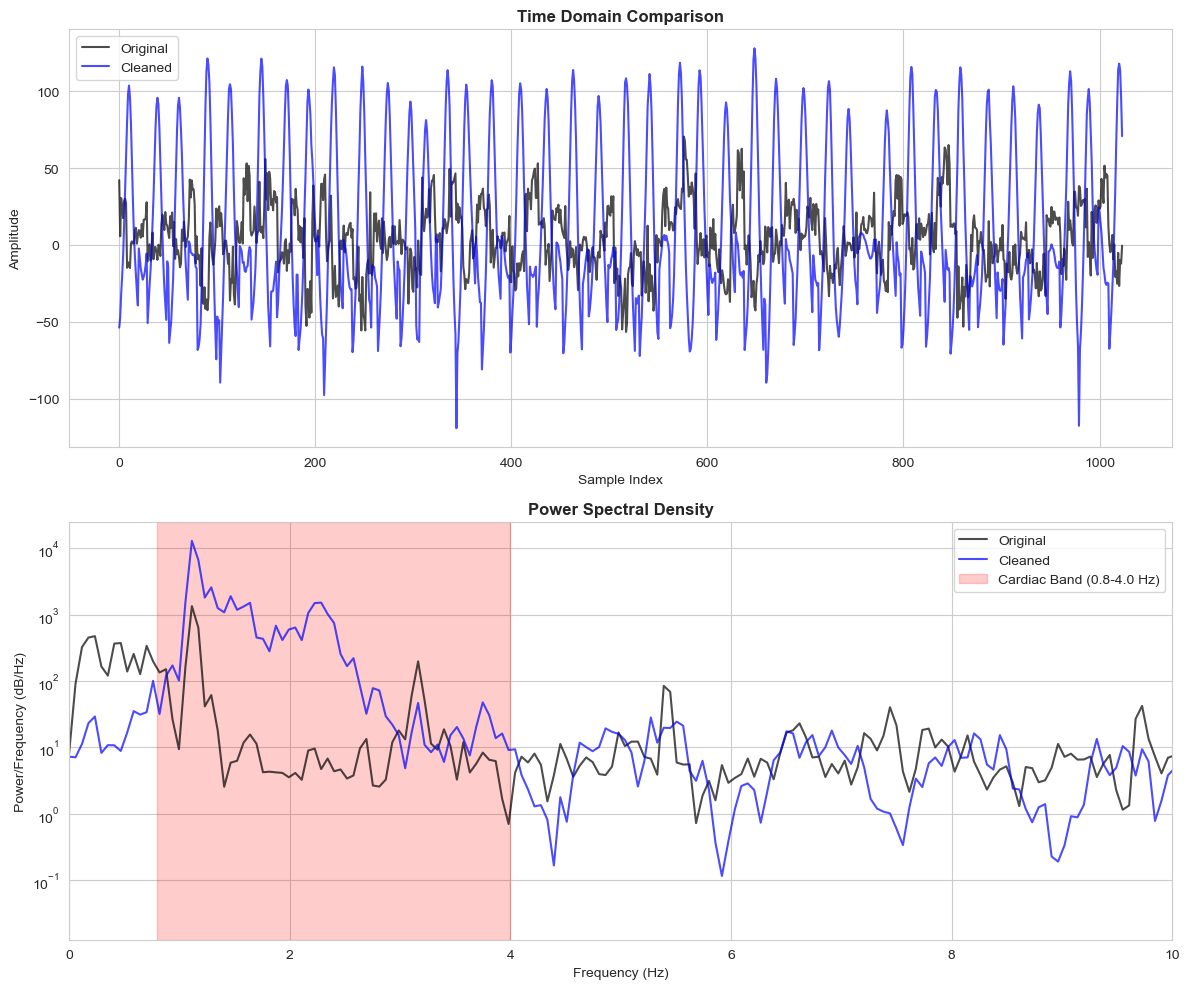

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

def plot_frequency_analysis(dataset, start_idx=0, segment_length=1024):
    """
    Plot frequency domain analysis of original and processed signals
    
    Parameters:
        dataset: DataFrame containing the signals
        start_idx: Starting index for the analysis
        segment_length: Length of segment to analyze
    """
    end_idx = start_idx + segment_length
    
    # Extract signals
    original = dataset['bvp'].iloc[start_idx:end_idx].values
    cleaned = dataset['bvp_cleaned'].iloc[start_idx:end_idx].values
    
    # Compute power spectral density
    fs = 30  # Sampling frequency (Hz)
    f_orig, psd_orig = signal.welch(original, fs, nperseg=512)
    f_clean, psd_clean = signal.welch(cleaned, fs, nperseg=512)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot time domain signals
    ax1.plot(original, 'k-', alpha=0.7, label='Original')
    ax1.plot(cleaned, 'b-', alpha=0.7, label='Cleaned')
    ax1.set_title('Time Domain Comparison', fontweight='bold')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    
    # Plot frequency domain
    ax2.semilogy(f_orig, psd_orig, 'k-', alpha=0.7, label='Original')
    ax2.semilogy(f_clean, psd_clean, 'b-', alpha=0.7, label='Cleaned')
    
    # Highlight cardiac frequency band
    ax2.axvspan(0.8, 4.0, color='red', alpha=0.2, label='Cardiac Band (0.8-4.0 Hz)')
    
    ax2.set_title('Power Spectral Density', fontweight='bold')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power/Frequency (dB/Hz)')
    ax2.set_xlim([0, 10])
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('frequency_analysis.png', dpi=300)
    plt.show()


plot_frequency_analysis(processed_df, start_idx=1000)

### Cardiac Component Enhancement Visualization

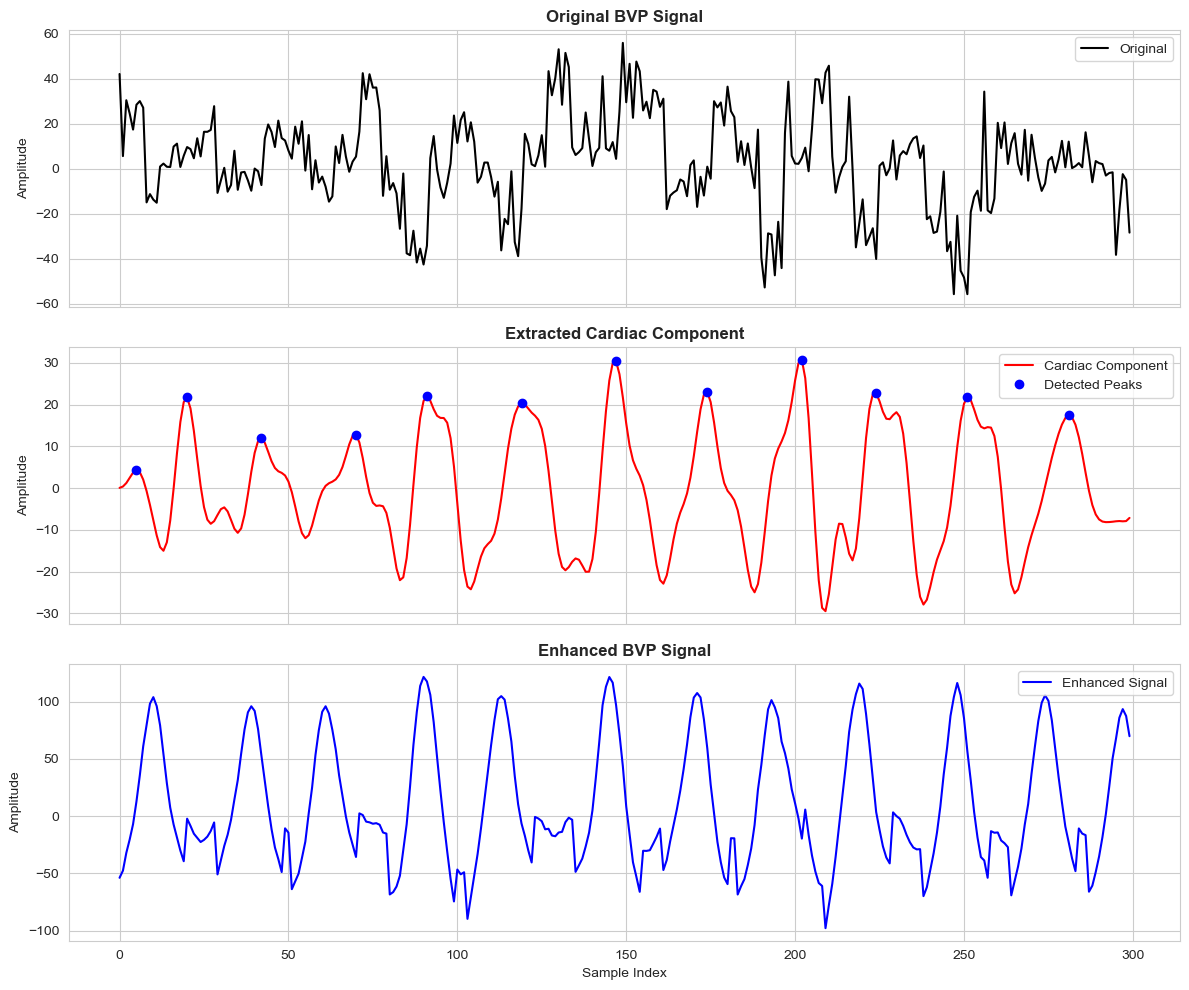

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfilt, find_peaks

def visualize_cardiac_enhancement(dataset, start_idx=0, duration=300):
    """
    Visualize the cardiac component enhancement process
    
    Parameters:
        dataset: DataFrame containing the signals
        start_idx: Starting index for the plot
        duration: Number of samples to plot
    """
    end_idx = start_idx + duration
    
    # Extract signal
    original = dataset['bvp'].iloc[start_idx:end_idx].values
    cleaned = dataset['bvp_cleaned'].iloc[start_idx:end_idx].values
    
    # Extract cardiac component
    sos = butter(4, [0.9, 3.0], btype='bandpass', fs=30, output='sos')
    cardiac = sosfilt(sos, original)
    
    # Find peaks
    peaks, _ = find_peaks(cardiac, distance=15, prominence=0.1)
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Plot original signal
    ax1.plot(original, 'k-', label='Original')
    ax1.set_title('Original BVP Signal', fontweight='bold')
    ax1.set_ylabel('Amplitude')
    ax1.legend(loc='upper right')
    
    # Plot extracted cardiac component
    ax2.plot(cardiac, 'r-', label='Cardiac Component')
    ax2.plot(peaks, cardiac[peaks], 'bo', label='Detected Peaks')
    ax2.set_title('Extracted Cardiac Component', fontweight='bold')
    ax2.set_ylabel('Amplitude')
    ax2.legend(loc='upper right')
    
    # Plot cleaned signal
    ax3.plot(cleaned, 'b-', label='Enhanced Signal')
    ax3.set_title('Enhanced BVP Signal', fontweight='bold')
    ax3.set_xlabel('Sample Index')
    ax3.set_ylabel('Amplitude')
    ax3.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig('cardiac_enhancement.png', dpi=300)
    plt.show()


visualize_cardiac_enhancement(processed_df, start_idx=1000)

### SNR vs. Amplitude Preservation Tradeoff

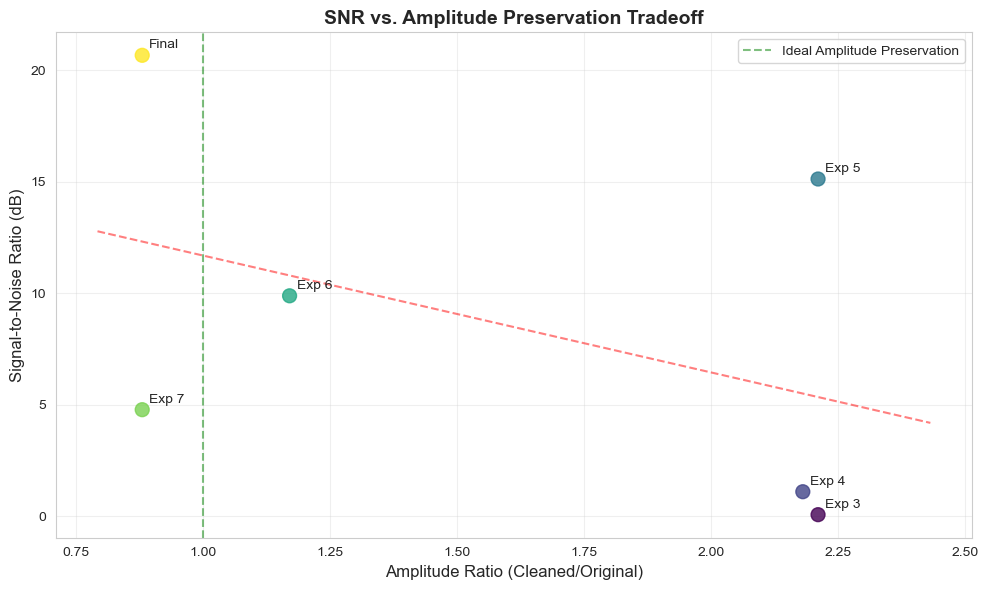

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data for SNR vs. Amplitude Preservation
experiments = ['Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Final']
snr_values = [0.07, 1.10, 15.13, 9.89, 4.78, 20.68]
amplitude_ratio = [2.21, 2.18, 2.21, 1.17, 0.88, 0.88]  # Ratio of cleaned to original std

# Create figure
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

# Create scatter plot
plt.scatter(amplitude_ratio, snr_values, s=100, c=range(len(experiments)), cmap='viridis', alpha=0.8)

# Add labels for each point
for i, exp in enumerate(experiments):
    plt.annotate(exp, (amplitude_ratio[i], snr_values[i]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=10)

# Add trend line
z = np.polyfit(amplitude_ratio, snr_values, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(amplitude_ratio)*0.9, max(amplitude_ratio)*1.1, 100)
plt.plot(x_trend, p(x_trend), "r--", alpha=0.5)

# Add reference line for ideal amplitude preservation
plt.axvline(x=1.0, color='g', linestyle='--', alpha=0.5, label='Ideal Amplitude Preservation')

# Add labels and title
plt.xlabel('Amplitude Ratio (Cleaned/Original)', fontsize=12)
plt.ylabel('Signal-to-Noise Ratio (dB)', fontsize=12)
plt.title('SNR vs. Amplitude Preservation Tradeoff', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('snr_amplitude_tradeoff.png', dpi=300)
plt.show()